<a href="https://colab.research.google.com/github/estevaosmith/Portifolio/blob/main/PROJETO_Churn_Prediction_com_RandomForestClassificator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Churn Prediction

*A taxa de abandono, conhecida como churn rate, reflete a porcentagem de clientes que deixam sua base de usuários. Em plataformas como Spotify ou Netflix, ela indica quantas assinaturas foram canceladas. Sua análise é crucial para a gestão, revelando possíveis problemas a serem resolvidos ao longo do tempo.*

<p align=center>
<img src="https://img.freepik.com/fotos-gratis/jovem-adulto-pressionando-o-botao-da-campainha_23-2149586572.jpg?t=st=1710190440~exp=1710194040~hmac=5fb8d688384c87a5af0c9814e23ae1710f3b5775b52022abd1e9d4f1ff6a2323&w=996" width="60%"></p>

Além disso, o churn pode antecipar cancelamentos e orientar ações específicas para reter clientes. É vital destacar que o Custo de Aquisição de Cliente (CAC) geralmente supera o custo de manutenção, tornando essencial controlar o churn rate, pois altas taxas são indesejáveis.







## Aquisição dos Dados

Os dados utilizados neste projeto foram inicialmente disponibilizados na [plataforma de ensino da IBM Developer](https://developer.ibm.com/technologies/data-science/patterns/predict-customer-churn-using-watson-studio-and-jupyter-notebooks/#) e tratam de um problema comum enfrentado por empresas de telecomunicações. O conjunto de dados completo está acessível através [deste link](https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv).

Embora não haja informações explicitamente fornecidas, os nomes das colunas permitem uma compreensão do problema em questão.

In [ ]:
# instalar Pandas Profiling
!pip install scikit-plot -q
!pip install imbalanced-learn -q

In [ ]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# importar os pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# random seed
np.random.seed(42)

# importar os dados
DATA_PATH = "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)

# ver as 5 primeiras entradas
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
print("Linhas:\t\t{}".format(df.shape[0]))
print("Colunas:\t{}".format(df.shape[1]))

Linhas:		7043
Colunas:	21


Como podemos ver, o dataset possui 7043 e 21 colunas.



## Análise exploratória

Agora, preciso realizar uma análise exploratória para garantir que os dados estejam devidamente tratados antes de implementar o modelo de Machine Learning.

In [ ]:
print("Dados ausentes (total):\t{}\n".format(df.isnull().sum().values.sum()))
print(df.isnull().sum() / df.shape[0])
print("\nNomes das features:\n{}\n".format(df.columns.values))
print("Valores únicos (por coluna):\n{}\n".format(df.nunique()))
print("Tipos de Variáveis (por coluna)\n{}".format(df.dtypes))

Dados ausentes (total):	0

customerID          0.0
gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64

Nomes das features:
['customerID' 'gender' 'SeniorCitizen' 'Partner' 'Dependents' 'tenure'
 'PhoneService' 'MultipleLines' 'InternetService' 'OnlineSecurity'
 'OnlineBackup' 'DeviceProtection' 'TechSupport' 'StreamingTV'
 'StreamingMovies' 'Contract' 'PaperlessBilling' 'PaymentMethod'
 'MonthlyCharges' 'TotalCharges' 'Churn']

Valores únicos (por coluna):
customerID          7043
gender                 2
SeniorCitizen          2
Partner             

Algumas observações importantes foram feitas durante esta fase inicial de conscientização:
1. A variável alvo está na coluna Churn.
2. A coluna TotalCharges deveria ser do tipo float, mas atualmente é uma string.
3. Muitas características precisam ser convertidas em valores numéricos.


## Tratar os dados
Após esta breve análise, é necessário preparar os dados. Vou utilizar o *LabelEncoder* para transformar todas as categorias em 0 ou 1, tornando assim o modelo de Machine Learning viável.

In [ ]:
def converter_str_float(entrada):

    try:
        return float(entrada)
    except ValueError:
        return np.nan


df_clean = df.copy()

# remover coluna costumerID
df_clean.drop("customerID", axis=1, inplace=True)

# converter as strings de TotalCharges para float
df_clean["TotalCharges"] = df_clean["TotalCharges"].apply(converter_str_float)

# verificar entradas ausentes
print("Dados ausentes em 'TotalCharges' (antes):\t{}\n".format(df_clean["TotalCharges"].isnull().sum()))

# substituir os dados ausentes pelo valor da mediana
TotalChargesMedian = df_clean.TotalCharges.median()
df_clean["TotalCharges"].fillna(TotalChargesMedian, inplace=True)

# pré processar as variáveis
binary_var = df_clean.nunique()[df_clean.nunique() == 2].keys().tolist()
num_var = [col for col in df_clean.select_dtypes(['int', 'float']).columns.tolist() if col not in binary_var]
cat_var = [col for col in df_clean.columns.tolist() if col not in binary_var + num_var]

# criar uma cópia do dataframe
df_proc = df_clean.copy()

# Label Encoding para as variáveis Binárias
le = LabelEncoder()
for i in binary_var:
    df_proc[i] = le.fit_transform(df_proc[i])

# Encoding para colunas categóricas com múltiplas classes
df_proc = pd.get_dummies(df_proc, columns=cat_var)

# ver as 5 primeiras entradas do novo dataframe
df_proc.head()


Dados ausentes em 'TotalCharges' (antes):	11



,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,...,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108.15,1,...,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,...,1,0,0,1,0,0,0,0,1,0


Podemos observar que a classe "No" ocorre com uma frequência significativamente maior do que a classe "Yes". Esse fato será levado em consideração durante a construção do modelo de machine learning.

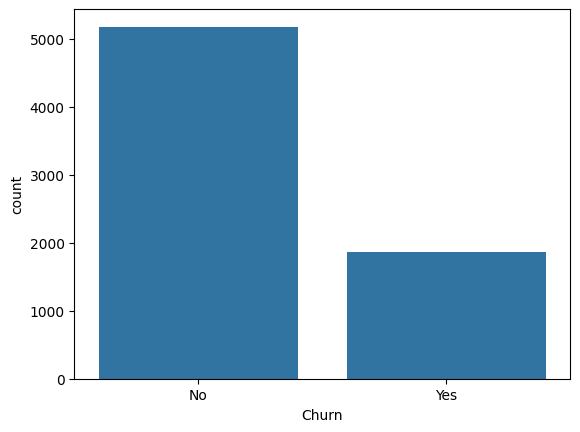

In [ ]:
sns.countplot(data=df_clean, x='Churn');

## Modelo de Machine Learning

É fundamental, desde o início, dividir os dados em conjuntos de treinamento e teste. Os dados de teste serão reservados exclusivamente para a fase final do projeto, proporcionando uma avaliação mais precisa e realista.

In [ ]:
X = df_proc.drop('Churn', axis=1)
y = df_proc['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
#  padronizar os  dados,
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

rus = RandomUnderSampler()
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)



Decidi utilizar o **RandomForestClassificator** pois ele possui capacidade de lidar bem com uma ampla variedade de problemas de classificação, incluindo conjuntos de dados grandes e complexos, sem a necessidade de ajustes finos extensivos nos hiperparâmetros. Além disso, ele é menos suscetível ao overfitting em comparação com uma única árvore de decisão.Fiz testes com diversos outros modelos; no entanto, o resultado não foi muito satisfatório.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Acurácia: 0.7575241340147644

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.78      0.93      0.85      1282
           1       0.62      0.29      0.39       479

    accuracy                           0.76      1761
   macro avg       0.70      0.61      0.62      1761
weighted avg       0.73      0.76      0.72      1761

AUC: 0.6112



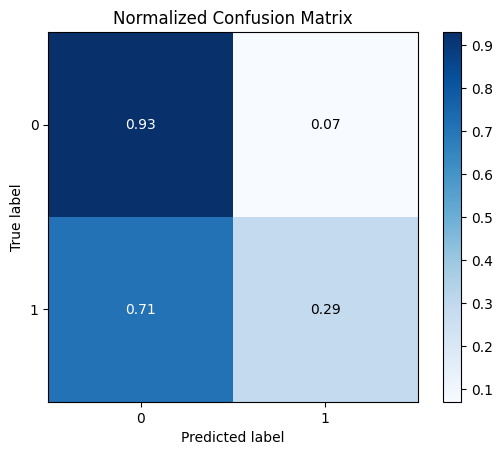

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

model = RandomForestClassifier(n_estimators=100, random_state=42)  #
model.fit(X_train_resampled, y_train_resampled)

# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)

# Avaliar o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia:", accuracy)

# Imprimir relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

# imprimir a área sob a curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

# plotar matriz de confusão
plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()



## Conclusões
Apesar do tratamento de dados ter demandado certo trabalho, o modelo teve um desempenho razoavelmente bom.

Também é importante ressaltar que não realizei a otimização de hiperparâmetros, pois o modelo que escolhi não requer isso explicitamente; no entanto, os resultados poderiam ter sido melhores se a otimização tivesse sido feita, talvez em algum outro modelo.

Em um projeto maior, também seria adequado aplicar técnicas como Feature Selection  e Feature Engineering, afim de melhorar a otimização do modelo.
